In [4]:
import sys, os
import time, pickle
sys.path.append("/Users/chilpert/Dev/pyproteinsExt/src")
sys.path.append("/Users/chilpert/Dev/pyproteins/src")
import pyproteinsExt.topology as topology
import seaborn as sns
from matplotlib import pyplot as plt
import re
import pandas as pd
from ete3 import NCBITaxa,TreeStyle,NodeStyle
from sklearn import mixture
from scipy import stats
import numpy as np
import math
from scipy import stats
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
def save(data, tag=None):
    saveDir="/Volumes/arwen/mobi/group/NOX_clean/pickle_saved"
    timestr = time.strftime("%Y%m%d-%H%M%S")
    fTag = "NOX_annotation_" + tag + "_" if tag else "NOX_annotation_"
    fSerialDump = fTag + timestr + ".pickle"
    with open(saveDir + '/' + fSerialDump, 'wb') as f:
        pickle.dump(data, f)
    print('data structure saved to', saveDir + '/' + fSerialDump)

def load(fileName):
    saveDir="/Volumes/arwen/mobi/group/NOX_clean/pickle_saved"
    print(saveDir+"/"+fileName)
    d = pickle.load( open(saveDir + "/" + fileName, "rb" ) )
    print("restore a annotated container of ", len(d), "elements")
    return d

In [6]:
data=load("NOX_annotation_refined23_20190808-153047.pickle")

/Volumes/arwen/mobi/group/NOX_clean/pickle_saved/NOX_annotation_refined23_20190808-153047.pickle
restore a annotated container of  807 elements


## 1. Extract protein fragments

In [7]:
data.separate_seq_into_fragments()

## 2. Size distributions

#### N-ter unannotated fragments

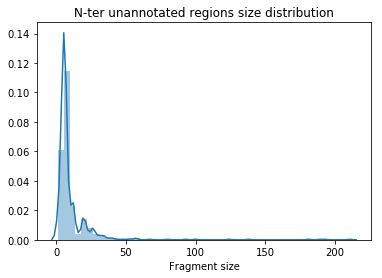

In [8]:
list_size=[len(e.Nter_UR_fragment["seq"]) for e in data]
list_size.sort()
plot=sns.distplot(list_size,axlabel="Fragment size").set_title("N-ter unannotated regions size distribution")
plot.figure.savefig("/Users/chilpert/Results/NOX_visu_clean/Topology_study/Nter_UR_size.pdf")

#### C-ter unannotated fragments

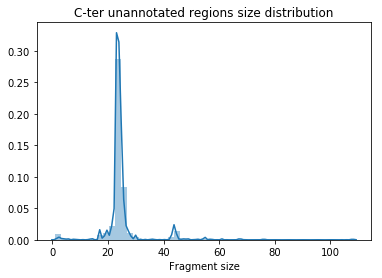

In [9]:
list_size=[len(e.Cter_UR_fragment["seq"]) for e in data]
plot=sns.distplot(list_size,axlabel="Fragment size").set_title("C-ter unannotated regions size distribution")
plot.figure.savefig("/Users/chilpert/Results/NOX_visu_clean/Topology_study/Cter_UR_size.pdf")

#### FAD_binding fragments

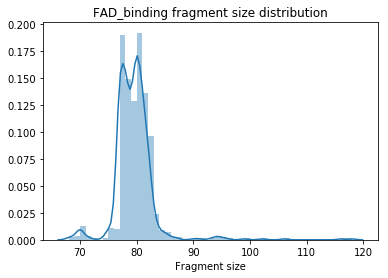

In [10]:
list_size=[len(f["seq"]) for e in data for f in e.annotated_domains_fragments if f["name"]=="fad_binding_prokaryotes"]
plot=sns.distplot(list_size,axlabel="Fragment size").set_title("FAD_binding fragment size distribution")
plot.figure.savefig("/Users/chilpert/Results/NOX_visu_clean/Topology_study/FAD_binding_size.pdf")

#### NAD_binding fragments

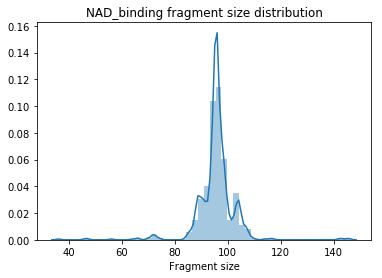

In [11]:
list_size=[len(f["seq"]) for e in data for f in e.annotated_domains_fragments if f["name"]=="nad_binding_prokaryotes"]
plot=sns.distplot(list_size,axlabel="Fragment size").set_title("NAD_binding fragment size distribution")
plot.figure.savefig("/Users/chilpert/Results/NOX_visu_clean/Topology_study/NAD_binding_size.pdf")

#### Ferric reductase fragments

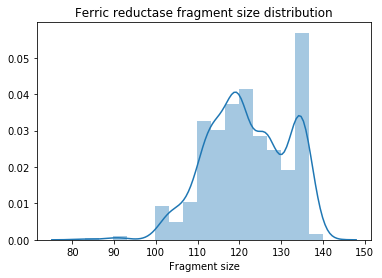

In [12]:
list_size=[len(f["seq"]) for e in data for f in e.annotated_domains_fragments if f["name"]=="ferric_reduct_prokaryotes"]
plot=sns.distplot(list_size,axlabel="Fragment size").set_title("Ferric reductase fragment size distribution")
plot.figure.savefig("/Users/chilpert/Results/NOX_visu_clean/Topology_study/Ferric_reduct_size.pdf")

#### Helix number

In [13]:
list_helix_number=[len(e.helix_fragments) for e in data]
dic_number_helix={}
for n in list_helix_number: 
    if n not in dic_number_helix:
        dic_number_helix[n]=1
    dic_number_helix[n]+=1   

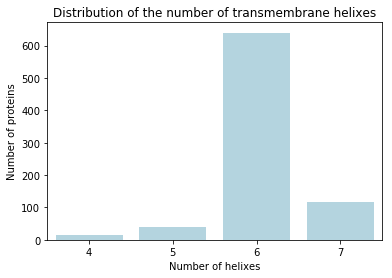

In [14]:
plot=sns.barplot(x=list(dic_number_helix.keys()),y=list(dic_number_helix.values()),color="lightblue").set(xlabel="Number of helixes",ylabel="Number of proteins",title="Distribution of the number of transmembrane helixes")
plt.savefig("/Users/chilpert/Results/NOX_visu_clean/Topology_study/helix_number.pdf")

#### Helix size

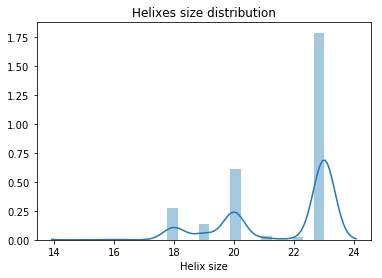

In [15]:
list_size=[len(f["seq"]) for e in data for f in e.helix_fragments]
plot=sns.distplot(list_size).set(xlabel="Helix size",title="Helixes size distribution")
plt.savefig("/Users/chilpert/Results/NOX_visu_clean/Topology_study/helix_size.pdf")

#### Intracellular loops size

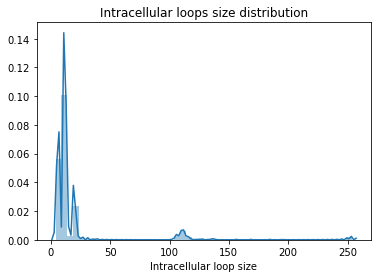

In [16]:
list_size_intra=[len(f["seq"]) for e in data for f in e.loop_fragments if "inside_loop" in f["name"]]
plot=sns.distplot(list_size_intra).set(xlabel="Intracellular loop size",title="Intracellular loops size distribution")
plt.savefig("/Users/chilpert/Results/NOX_visu_clean/Topology_study/intra_loops_size.pdf")

#### Extracellular loops size

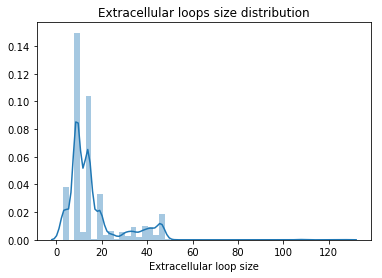

In [17]:
list_size_extra=[len(f["seq"]) for e in data for f in e.loop_fragments if "outside_loop" in f["name"]]
plot=sns.distplot(list_size_extra).set(xlabel="Extracellular loop size",title="Extracellular loops size distribution")
plt.savefig("/Users/chilpert/Results/NOX_visu_clean/Topology_study/extra_loops_size.pdf")

## 3. Identify problematic proteins

### Check domains order

In [18]:
core_domains=["ferric_reduct_prokaryotes","nad_binding_prokaryotes","fad_binding_prokaryotes"]
check_length=set()
list_orders=[]
list_orders_all=[]
for e in data : 
    core_domains_fragments=[f for f in e.annotated_domains_fragments if f["name"] in core_domains]
    check_length.add(len(core_domains_fragments))
    order=[f["name"] for f in core_domains_fragments]
    order_all=[f["name"] for f in e.annotated_domains_fragments]
    if order not in list_orders: 
        list_orders.append(order)
    if order_all not in list_orders_all:
        list_orders_all.append(order_all)

In [19]:
print(list_orders)
print(list_orders_all)

[['ferric_reduct_prokaryotes', 'fad_binding_prokaryotes', 'nad_binding_prokaryotes']]
[['ferric_reduct_prokaryotes', 'fad_binding_prokaryotes', 'nad_binding_prokaryotes']]


Core domains order is always the same : ferric reductase, fad_binding, nad_binding. No problematic proteins. 

### Check if ferric reductase is still in transmembrane region

In [20]:
starts_before=[]
ends_after=[]
list_difference=[]
nb_helix_sup_100={}
nb_helix_inf_100={}
list_sup_100=[]
for e in data : 
    ferric_position=[(f["start"],f["end"]) for f in e.annotated_domains_fragments if f["name"]=="ferric_reduct_prokaryotes"][0]
    transmembrane_position=(e.helix_fragments[0]["start"],e.helix_fragments[-1]["end"])
    len_ferric=ferric_position[1]-ferric_position[0]
    len_transmembrane=transmembrane_position[1]-transmembrane_position[0]
    if len_ferric > len_transmembrane: 
        print(e.prot,"Ferric reductase longer than transmembrane region")
    if ferric_position[0]<transmembrane_position[0]:
        starts_before.append({"prot":e.prot,"shift":transmembrane_position[0]-ferric_position[0]})
    if ferric_position[1]>transmembrane_position[1]:
        ends_after.append({"prot":e.prot,"shift":ferric_position[1]-transmembrane_position[1]})
   
    difference=len_transmembrane-len_ferric 
    nb_helix=len(e.helix_fragments)
    if difference > 100: 
        list_sup_100.append(e)
        if nb_helix not in nb_helix_sup_100: 
            nb_helix_sup_100[nb_helix]=0
        nb_helix_sup_100[nb_helix]+=1                     
    else: 
        if nb_helix not in nb_helix_inf_100:
            nb_helix_inf_100[nb_helix]=0
        nb_helix_inf_100[nb_helix]+=1
    list_difference.append(difference)

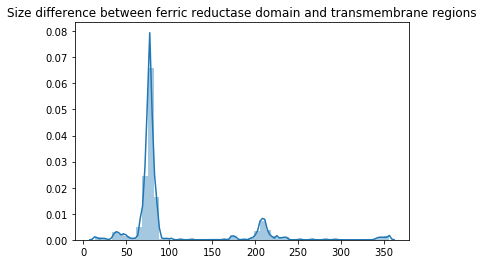

In [21]:
plot=sns.distplot(list_difference).set_title("Size difference between ferric reductase domain and transmembrane regions")

In [22]:
print(nb_helix_sup_100)
print(nb_helix_inf_100)

{7: 117, 6: 16, 5: 1}
{6: 623, 5: 37, 4: 13}


Proteins with ferric reductase and transmembrane region size difference > 100 have most of the time 7 helixes. Maybe the 7th helix is wrong predicted. 

In [23]:
print(starts_before)
print(len(starts_before))
print(ends_after)

[{'prot': 'tr|A0A2G4B6C3|A0A2G4B6C3_VIBSP', 'shift': 26}, {'prot': 'tr|A0A1M2TZE2|A0A1M2TZE2_ECOLX', 'shift': 26}, {'prot': 'tr|A0A1M1NE58|A0A1M1NE58_ECOLX', 'shift': 26}, {'prot': 'tr|D3L7W7|D3L7W7_OENOE', 'shift': 1}, {'prot': 'tr|A0A2A4QPH1|A0A2A4QPH1_9RHOB', 'shift': 1}, {'prot': 'tr|A0A090P8E6|A0A090P8E6_9VIBR', 'shift': 20}, {'prot': 'tr|A0A1E2VNV3|A0A1E2VNV3_9ENTR', 'shift': 15}, {'prot': 'tr|A0A0G0QUY4|A0A0G0QUY4_9BACT', 'shift': 1}, {'prot': 'tr|A0A349W7G9|A0A349W7G9_9BURK', 'shift': 24}, {'prot': 'tr|A0A376LV77|A0A376LV77_ECOLX', 'shift': 15}, {'prot': 'tr|A0A161R3H5|A0A161R3H5_ECOLX', 'shift': 26}, {'prot': 'tr|A0A1Q6A6J6|A0A1Q6A6J6_9SPHI', 'shift': 18}, {'prot': 'tr|A0A1Q9FBS2|A0A1Q9FBS2_OENOE', 'shift': 1}, {'prot': 'tr|A0A231R527|A0A231R527_9BACL', 'shift': 6}, {'prot': 'tr|Z2EV26|Z2EV26_VIBPH', 'shift': 6}]
15
[]


No proteins have ferric reductase domain longer than transmembrane domain.  
15 proteins have ferric reductase domain that starts earlier than transmembrane domain, with shift between 1 and 26.  
No proteins have ferric reductase domain that ends after transmembrane domain.  
So 792 proteins have ferric reductase domains contains in transmembrane domain, and the 15 others with overlap don't have an important one so it's not considered as problematic.

### FAD/NAD position

Check if FAD/NAD overlap helix domain (from first to last helix) and where it overlaps (in loop/helix, last or other ?)

In [24]:
def is_overlap(start1,end1,start2,end2):
    residues1=set(list(range(start1,end1+1)))
    residues2=set(list(range(start2,end2+1)))
    if residues1.intersection(residues2):
        return True
    return False

def is_FAD_overlap(e):
    fad=[f for f in e.annotated_domains_fragments if f["name"]=="fad_binding_prokaryotes"][0]
    return is_overlap(e.helix_fragments[0]["start"],e.helix_fragments[-1]["end"],fad["start"],fad["end"])

def overlap_loop_or_helix(e, start, end):
    overlaps = []
    loop_number = 0
    helix_number = 0
    for l in e.loop_fragments:
        loop_number += 1 
        if is_overlap(start, end, l["start"], l["end"]):
            overlaps.append({'name' : l["name"], "number":loop_number})
    for h in e.helix_fragments: 
        helix_number += 1
        if is_overlap(start, end, h["start"], h["end"]):
            overlaps.append({'name' : h["name"], "number": helix_number})
            
    if len(overlaps) == 0:
        case = "no_overlap"
        
    elif len(overlaps) == 1: 
        overlap = overlaps[0]
        if "loop" in overlap["name"] and overlap["number"] == len(e.loop_fragments):
            case = "last_loop"
        elif "loop" in overlap["name"] and overlap["number"] != len(e.loop_fragments):
            case = "other_loop"
        elif "helix" in overlap["name"] and overlap["number"] == len(e.helix_fragments):  
            case = "last_helix"
        elif "helix" in overlap["name"] and overlap["number"] != len(e.helix_fragments):  
            case = "other_helix"   
        else:
            case = "other_case"
            
    elif len(overlaps) > 1: 
        case = "several_elements"
        
    return overlaps, case

In [25]:
fad_overlap_dic = {"no_overlap": set(), "last_loop": set(), "last_helix": set(), "other_loop": set(),
                   "other_helix": set(), "other_case": set(), "several_elements": set()}

nad_overlap_dic = {"no_overlap": set(), "last_loop": set(), "last_helix": set(), "other_loop": set(),
                   "other_helix": set(), "other_case": set(), "several_elements" : set()}
  
for e in data: 
    fad = [f for f in e.annotated_domains_fragments if f["name"]=="fad_binding_prokaryotes"][0]
    nad = [f for f in e.annotated_domains_fragments if f["name"]=="nad_binding_prokaryotes"][0]
    fad_overlap, fad_overlap_case = overlap_loop_or_helix(e, fad["start"], fad["end"])
    fad_overlap_dic[fad_overlap_case].add(e.prot)
    nad_overlap, nad_overlap_case = overlap_loop_or_helix(e, nad["start"], nad["end"])
    nad_overlap_dic[nad_overlap_case].add(e.prot) 

In [26]:
for f in fad_overlap_dic:
    print("= FAD", f, len(fad_overlap_dic[f]))
    for n in nad_overlap_dic:
        print("== NAD", n, len(nad_overlap_dic[n].intersection(fad_overlap_dic[f])))
    print()    

= FAD no_overlap 675
== NAD no_overlap 675
== NAD last_loop 0
== NAD last_helix 0
== NAD other_loop 0
== NAD other_helix 0
== NAD other_case 0
== NAD several_elements 0

= FAD last_loop 130
== NAD no_overlap 0
== NAD last_loop 16
== NAD last_helix 114
== NAD other_loop 0
== NAD other_helix 0
== NAD other_case 0
== NAD several_elements 0

= FAD last_helix 2
== NAD no_overlap 2
== NAD last_loop 0
== NAD last_helix 0
== NAD other_loop 0
== NAD other_helix 0
== NAD other_case 0
== NAD several_elements 0

= FAD other_loop 0
== NAD no_overlap 0
== NAD last_loop 0
== NAD last_helix 0
== NAD other_loop 0
== NAD other_helix 0
== NAD other_case 0
== NAD several_elements 0

= FAD other_helix 0
== NAD no_overlap 0
== NAD last_loop 0
== NAD last_helix 0
== NAD other_loop 0
== NAD other_helix 0
== NAD other_case 0
== NAD several_elements 0

= FAD other_case 0
== NAD no_overlap 0
== NAD last_loop 0
== NAD last_helix 0
== NAD other_loop 0
== NAD other_helix 0
== NAD other_case 0
== NAD several_element

There are 4 possible cases : 
* Group 1 : FAD and NAD domains doesn't overlap helix domain (675 proteins)
* Group 2 : FAD domain overlaps last loop, NAD domain overlaps last helix (114 proteins)
* Group 3 : FAD and NAD domains overlaps last loop (16 proteins)
* Group 4 : FAD domain overlaps last helix, NAD domains doesn't overlap (2 proteins)

In [40]:
all_proteins = [e.prot for e in data]
group1 = []
group2 = []
group3 = []
group4 = []
for p in all_proteins:
    if p in fad_overlap_dic["no_overlap"] and p in nad_overlap_dic["no_overlap"]:
        group1.append(p)
    elif p in fad_overlap_dic["last_loop"] and p in nad_overlap_dic["last_helix"]:
        group2.append(p)
    elif p in fad_overlap_dic["last_loop"] and p in nad_overlap_dic["last_loop"]:
        group3.append(p)
    elif p in fad_overlap_dic["last_helix"] and p in nad_overlap_dic["no_overlap"]:
        group4.append(p)
    else:
        print("OO")

### Is protein problematic ?

FAD/NAD domain can't be extracellular. There's configuration that will be not possible that we have to discarded. 
* Group 1 : Last loop has to be extracellular. 
* Group 2 : Last helix is discarded. Last loop has to be intracellular.
* Group 3 : Last loop has to be intracellular. 
* Group 4 : Last helix is discarded. Last loop has to be intracellular. 

When domains don't overlap, last loop has to be extracellular. When domains overlap, last loop has to be intracellular.

In [44]:
def get_last_loop_position(e):
    if "inside" in e.loop_fragments[-1]["name"]:
        return "intracellular"
    elif "outside" in e.loop_fragments[-1]["name"]:
        return "extracellular"

pandas_dic = {'prot': [], 'group': [], 'last_loop_position': [], 'nb_helix' : [], 'fad_length': [],
             'nad_length': [], 'ferric_reduc_length': []}
for e in data:
    pandas_dic["prot"].append(e.prot)
    if e.prot in fad_overlap_dic["no_overlap"]:
        pandas_dic["group"].append("no_overlap")
    else:
        pandas_dic["group"].append("overlap")
    pandas_dic["last_loop_position"].append(get_last_loop_position(e))
    pandas_dic["nb_helix"].append(len(e.helix_fragments))
    pandas_dic["fad_length"].append([len(f["seq"]) for f in e.annotated_domains_fragments if f["name"] == "fad_binding_prokaryotes"][0])
    pandas_dic["nad_length"].append([len(f["seq"]) for f in e.annotated_domains_fragments if f["name"] == "nad_binding_prokaryotes"][0])
    pandas_dic["ferric_reduc_length"].append([len(f["seq"]) for f in e.annotated_domains_fragments if f["name"] == "ferric_reduct_prokaryotes"][0])

all_df=pd.DataFrame(pandas_dic)

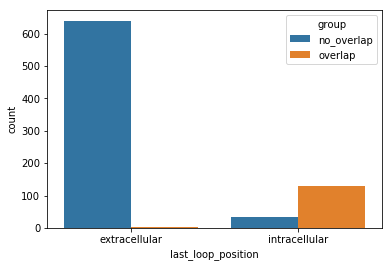

In [303]:
sns.countplot(x="last_loop_position",hue="group",data=all_df)

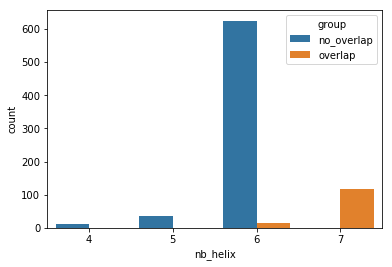

In [304]:
sns.countplot(x="nb_helix", hue="group", data=all_df)

In [305]:
pandas_length_dic = {'prot': [], 'type_length': [], 'length': [] ,'group': []}
for e in data: 
    pandas_length_dic['type_length'].append('fad_length')
    pandas_length_dic["prot"].append(e.prot)
    pandas_length_dic["length"].append([len(f["seq"]) for f in e.annotated_domains_fragments if f["name"] == "fad_binding_prokaryotes"][0])
    if e.prot in fad_overlap_dic["no_overlap"]:
        pandas_length_dic["group"].append("no_overlap")
    else:
        pandas_length_dic["group"].append("overlap")
    pandas_length_dic['type_length'].append('nad_length')
    pandas_length_dic["prot"].append(e.prot)
    pandas_length_dic["length"].append([len(f["seq"]) for f in e.annotated_domains_fragments if f["name"] == "nad_binding_prokaryotes"][0])
    if e.prot in fad_overlap_dic["no_overlap"]:
        pandas_length_dic["group"].append("no_overlap")
    else:
        pandas_length_dic["group"].append("overlap")
    pandas_length_dic['type_length'].append('ferric_reduct_length')
    pandas_length_dic["prot"].append(e.prot)
    pandas_length_dic["length"].append([len(f["seq"]) for f in e.annotated_domains_fragments if f["name"] == "ferric_reduct_prokaryotes"][0])
    if e.prot in fad_overlap_dic["no_overlap"]:
        pandas_length_dic["group"].append("no_overlap")
    else:
        pandas_length_dic["group"].append("overlap")
    
length_df = pd.DataFrame(pandas_length_dic)  

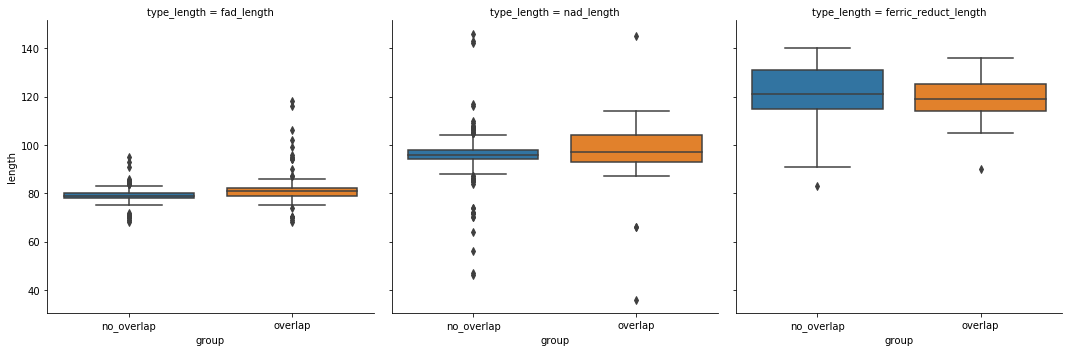

In [306]:
sns.catplot(x = "group", y = "length", col = "type_length", data = length_df, kind="box")

### Discard problematic proteins

In [51]:
print(" == Validated proteins")
discard_group1 = []
for p in group1:
    entry = data.entries[p]
    if get_last_loop_position(entry) == "extracellular":
        discard_group1.append(p)   
print("Group 1 :", len(discard_group1),"/",len(group1))   

discard_group2 = []
for p in group2:
    entry = data.entries[p]
    if get_last_loop_position(entry) == "intracellular":
        discard_group2.append(p)   
print("Group 2 :", len(discard_group2),"/",len(group2))  

discard_group3 = []
for p in group3:
    entry = data.entries[p]
    if get_last_loop_position(entry) == "intracellular":
        discard_group3.append(p)   
print("Group 3 :", len(discard_group3),"/",len(group3))  

discard_group4 = []
for p in group4:
    entry = data.entries[p]
    if get_last_loop_position(entry) == "intracellular":
        discard_group4.append(p)   
print("Group 4 :", len(discard_group4),"/",len(group4))  

 == Validated proteins
Group 1 : 640 / 675
Group 2 : 111 / 114
Group 3 : 16 / 16
Group 4 : 2 / 2


In [52]:
def filter_problematic_proteins(e):
    if e.prot in fad_overlap_dic["no_overlap"]:
        if get_last_loop_position(e) == "extracellular":
            return True
        if get_last_loop_position(e) == "intracellular":
            return False
    else:   
        if get_last_loop_position(e) == "extracellular":
            return False
        if get_last_loop_position(e) == "intracellular":
            return True

In [53]:
data_ok = data.filter(filter_problematic_proteins)
print(len(data_ok), "proteins are ok. We keep this proteins.")

769 proteins are ok. We keep this proteins.


In [310]:
save(data_ok, "validatedProteins")

data structure saved to /Volumes/arwen/mobi/group/NOX_clean/pickle_saved/NOX_annotation_validatedProteins_20190808-155906.pickle


In [351]:
mfasta = data_ok.proteins_mfasta()
with open("/Volumes/arwen/mobi/group/NOX_clean/NOX_fasta/predicted_NOX_proteins_validated.mfasta", "w") as o:
    o.write(mfasta)

## Try to create groups
### 1. Based on annotated percent

In [55]:
dic_group={}

In [74]:
annotated_percent_list=[]
annotated_percent_with_helix_list=[]
for e in data_ok: 
    annotated_residues=set()
    for f in e.annotated_domains_fragments: 
        annotated_residues.update(list(range(f["start"],f["end"]+1)))   
    annotated_percent=len(annotated_residues)/len(e.fasta.seq)
    annotated_residues.update(list(range(e.helix_fragments[0]["start"],e.helix_fragments[-1]["end"]+1)))
    annotated_percent_with_helix=len(annotated_residues)/len(e.fasta.seq)
    annotated_percent_list.append(annotated_percent)
    annotated_percent_with_helix_list.append(annotated_percent_with_helix)

* Annotated = just domains (NAD_binding, FAD_binding, Ferric_reductase and other if found)

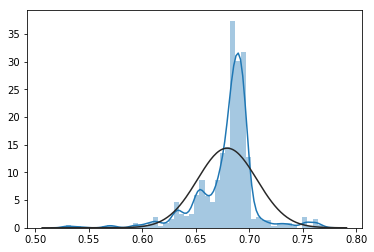

In [313]:
sns.distplot(annotated_percent_list,fit=stats.norm)

####  Try to modelize distribution

In [75]:
annotated_percent_format=np.array(annotated_percent_list).reshape(-1,1)

Mean 0.6794138502035515 Sigma 0.027765126377846328
Percentile 5 0.633744281378185
Percentile 95 0.725083419028918


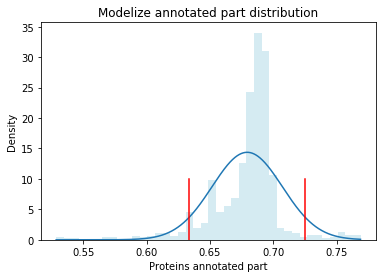

In [100]:
mean,sigma=stats.norm.fit(annotated_percent_list)
print("Mean", mean, "Sigma", sigma)
x=np.linspace(min(annotated_percent_list),max(annotated_percent_list),1000)
zscore1=stats.norm.ppf(0.05,mean,sigma)
zscore2=stats.norm.ppf(0.95,mean,sigma)
print("Percentile 5", zscore1)
print("Percentile 95", zscore2)
plt.plot(x,stats.norm.pdf(x,mean,sigma))
plt.hist(annotated_percent_format,density=True,color="lightblue",alpha=.5,bins=40)
plt.plot((zscore1,zscore1),(0,10),color="red")
plt.plot((zscore2,zscore2),(0,10),color="red")
plt.xlabel("Proteins annotated part")
plt.ylabel("Density")
plt.title("Modelize annotated part distribution")
plt.savefig("/Users/chilpert/Results/NOX_visu_clean/Topology_groups/annotated_percent.pdf")

#### Assign

In [81]:
for e in data_ok: 
    if not hasattr(e,"group_dic"):
        e.group_dic={}
    
    if not hasattr(e,"topology_dic"):
        e.topology_dic={}
        
    annotated_residues=set()
    for f in e.annotated_domains_fragments: 
        annotated_residues.update(list(range(f["start"],f["end"]+1)))   
    annotated_percent=len(annotated_residues)/len(e.fasta.seq)
    e.annotated_percent=annotated_percent
    if annotated_percent<=zscore1: 
        e.group_dic["annotated_fragment"]="small"
    elif annotated_percent>=zscore2:
        e.group_dic["annotated_fragment"]="big"
    else:
        e.group_dic["annotated_fragment"]="normal"

In [83]:
def filter_annotated_fragment(e,cat):
    if e.group_dic["annotated_fragment"]==cat:
        return True
    return False

small_annotated=data_ok.filter(filter_annotated_fragment,cat="small")
big_annotated=data_ok.filter(filter_annotated_fragment,cat="big")
normal_annotated=data_ok.filter(filter_annotated_fragment,cat="normal")
print("Small :", len(small_annotated))
print("Normal :", len(normal_annotated))
print("Big :", len(big_annotated))

Small : 50
Normal : 693
Big : 26


### 2. N-ter unannotated region

In [85]:
Nter_length=[]
for e in data_ok:
    Nter_length.append(len(e.Nter_UR_fragment["seq"]))

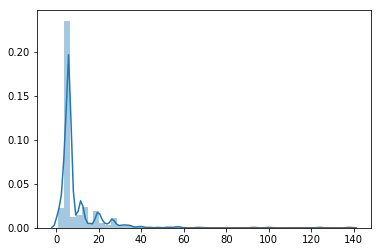

In [86]:
sns.distplot(Nter_length)

##### With 1 gaussian

Mean [9.61638492] Sigma 11.419067525228506
Percentile 5 [-9.16630972]
Percentile 95 [28.39907955]


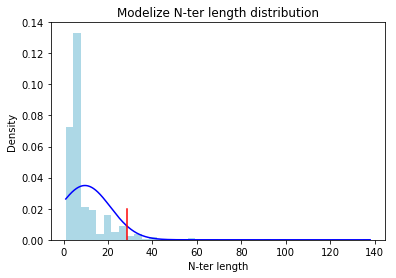

In [99]:
Nter_length_format=np.array(Nter_length).reshape(-1,1)
gaussian_model1=mixture.GaussianMixture(n_components=1)
gaussian_model1.fit(Nter_length_format)
mean1=gaussian_model1.means_[0]
sigma1=math.sqrt(gaussian_model1.covariances_[0])
weight1=gaussian_model1.weights_[0]
print("Mean", mean1, "Sigma", sigma1)

x=np.linspace(min(Nter_length),max(Nter_length),1000)
plt.clf()
plt.plot(x,weight1*stats.norm.pdf(x,mean1,sigma1),color="blue")
plt.hist(Nter_length_format,color="lightblue",bins=40, density = True)
zscore05=stats.norm.ppf(0.05,mean1,sigma1)
zscore95=stats.norm.ppf(0.95,mean1,sigma1)
print("Percentile 5",zscore05)
print("Percentile 95",zscore95)
plt.plot((zscore95,zscore95),(0,0.02),color="red")
plt.xlabel("N-ter length")
plt.ylabel("Density")
plt.title("Modelize N-ter length distribution")
plt.savefig("/Users/chilpert/Results/NOX_visu_clean/topology_groups/Nter_length.pdf")

##### Assign

In [94]:
zscore95=stats.norm.ppf(0.95,mean1,sigma1)
for e in data_ok: 
    if not hasattr(e,"group_dic"):
        e.group_dic={}    
    if len(e.Nter_UR_fragment["seq"]) >= zscore95: 
        e.group_dic["Nter_length"]="big"
    else:
        e.group_dic["Nter_length"]="normal"

### 3. C-ter unannotated region 

In [95]:
Cter_length=[]
for e in data_ok:
    Cter_length.append(len(e.Cter_UR_fragment["seq"]))

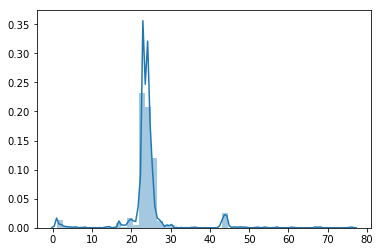

In [323]:
sns.distplot(Cter_length)

Gaussian1 - Mean : [24.35240572] Sigma: 6.903900898638735 1.0
Percentile 5 : [12.99649929] Percentile 95 : [35.70831215]


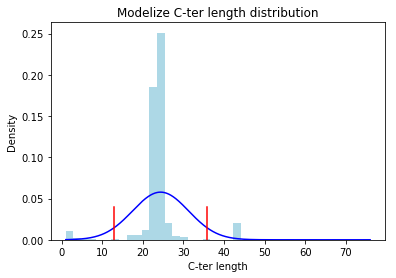

In [102]:
Cter_length_format=np.array(Cter_length).reshape(-1,1)
gaussian_model=mixture.GaussianMixture(n_components=1)
gaussian_model.fit(Cter_length_format)
mean1=gaussian_model.means_[0]
sigma1=math.sqrt(gaussian_model.covariances_[0])
weight1=gaussian_model.weights_[0]
print("Gaussian1 - Mean :",mean1,"Sigma:",sigma1,weight1)
#mean2=gaussian_model2.means_[1]
#sigma2=math.sqrt(gaussian_model2.covariances_[1])
#weight2=gaussian_model2.weights_[1]
#print(mean2,sigma2,weight2)

#mean3=gaussian_model2.means_[2]
#sigma3=math.sqrt(gaussian_model2.covariances_[2])
#print(mean3,sigma3)

#mean4=gaussian_model2.means_[3]
#sigma4=math.sqrt(gaussian_model2.covariances_[3])
#print(mean4,sigma4)

x=np.linspace(min(Cter_length),max(Cter_length),1000)
plt.clf()
plt.plot(x,stats.norm.pdf(x,mean1,sigma1),color="blue")
plt.hist(Cter_length_format,density=True,bins=40,color="lightblue")
zscore05=stats.norm.ppf(0.05,mean1,sigma1)
zscore95=stats.norm.ppf(0.95,mean1,sigma1)
plt.plot((zscore05,zscore05),(0,0.04),color="red")
plt.plot((zscore95,zscore95),(0,0.04),color="red")
plt.xlabel("C-ter length")
plt.ylabel("Density")
plt.title("Modelize C-ter length distribution")
print("Percentile 5 :",zscore05,"Percentile 95 :",zscore95)
plt.savefig("/Users/chilpert/Results/NOX_visu_clean/Topology_groups/Cter_length.pdf")

##### Assign

In [103]:
nb_small = 0
nb_big = 0
nb_normal = 0
for e in data_ok:
    if len(e.Cter_UR_fragment["seq"])<zscore05:
        e.group_dic["Cter_length"]="small"
        nb_small += 1
    elif len(e.Cter_UR_fragment["seq"])>zscore95:
        e.group_dic["Cter_length"]="big"
        nb_big += 1
    else:
        e.group_dic["Cter_length"]="normal"
        nb_normal += 1 
print("Small :", nb_small)
print("Normal :", nb_normal)
print("Big :", nb_big)

Small : 21
Normal : 706
Big : 42


### 4. Extracellular loops length

* All loops

In [104]:
all_length=[]
for e in data_ok:
    all_length+=[len(f["seq"]) for f in e.loop_fragments if "outside" in f["name"]]

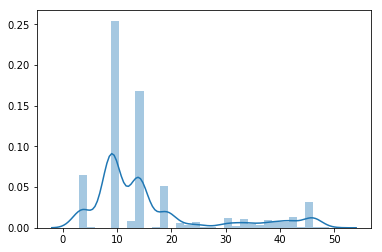

In [327]:
sns.distplot(all_length)

* Separate loops length

In [106]:
loop1_length=[]
for e in data_ok:
    loop1_length.append([len(f["seq"]) for f in e.loop_fragments if f["name"]=="outside_loop_1"][0])

In [107]:
loop2_length=[]
for e in data_ok:
    loop2_length.append([len(f["seq"]) for f in e.loop_fragments if f["name"]=="outside_loop_2"][0])

In [108]:
loop3_length=[]
for e in data_ok:
    if "outside_loop_3" in [f["name"] for f in e.loop_fragments]:
        loop3_length.append([len(f["seq"]) for f in e.loop_fragments if f["name"]=="outside_loop_3"][0])

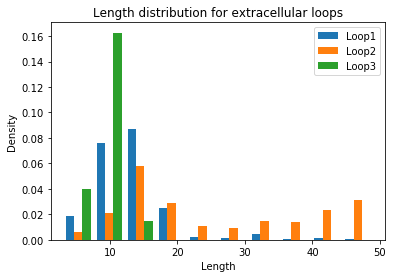

In [111]:
plt.clf()
plt.hist([loop1_length,loop2_length,loop3_length],label=["Loop1","Loop2","Loop3"], density = True)
plt.legend()
plt.xlabel("Length")
plt.ylabel("Density")
plt.title("Length distribution for extracellular loops")
plt.savefig("/Users/chilpert/Results/NOX_visu_clean/Topology_groups/extracellular_loops_length.pdf")

#### Loop 1

Gaussian : mean 12.945383615084525 sigma 6.224423023676727
Percentile 95 : 23.18364840125944


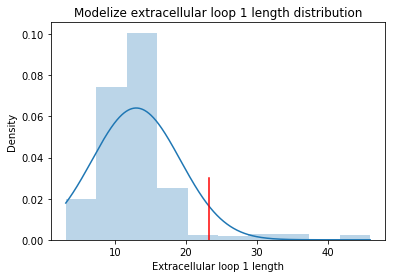

In [130]:
loop1_length_format=np.array(loop1_length).reshape(-1,1)
gaussian_model1=mixture.GaussianMixture(n_components=1)
gaussian_model1.fit(loop1_length_format)
mean1=gaussian_model1.means_[0]
sigma1=math.sqrt(gaussian_model1.covariances_[0])
print("Gaussian : mean",mean1[0],"sigma",sigma1)

x=np.linspace(min(loop1_length),max(loop1_length),1000)
plt.clf()
plt.plot(x,stats.norm.pdf(x,mean1,sigma1),color="#1f77b4")
plt.hist(loop1_length_format,density=True,color="#1f77b4",alpha=0.3)
zscore95=stats.norm.ppf(0.95,mean1,sigma1)
print("Percentile 95 :",zscore95[0])
plt.plot((zscore95,zscore95),(0,0.03),color="red")
plt.xlabel("Extracellular loop 1 length")
plt.ylabel("Density")
plt.title("Modelize extracellular loop 1 length distribution")
plt.savefig("/Users/chilpert/Results/NOX_visu_clean/Topology_groups/loop1_length.pdf")

##### Assign

In [131]:
nb_big = 0
nb_normal = 0
for e in data_ok: 
    length=[len(f["seq"]) for f in e.loop_fragments if f["name"]=="outside_loop_1"][0]
    e.loop1_length=length
    if length > zscore95: 
        e.group_dic["ol1"]="big"
        nb_big += 1 
    else:
        e.group_dic["ol1"]="normal"
        nb_normal += 1
print("Normal :", nb_normal)
print("Big :", nb_big)

Normal : 734
Big : 35


#### Loop 2

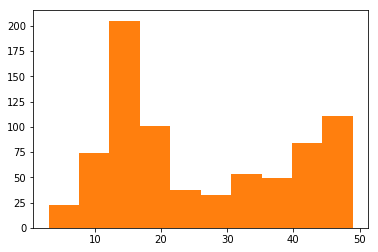

In [117]:
plt.clf()
plt.hist(loop2_length,color="#ff7f0e")
plt.show()

##### Assign

Gaussian 1 : mean 40.133074872591 sigma 5.708390510958994
Gaussian 2 : mean 14.718554768022058 sigma 5.708390510958994


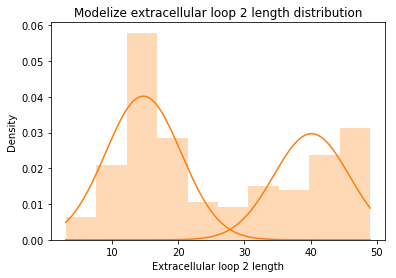

In [186]:
loop2_length_format=np.array(loop2_length).reshape(-1,1)
gaussian_model=mixture.GaussianMixture(n_components=2)
gaussian_model.fit(loop2_length_format)
mean1=gaussian_model.means_[0]
sigma1=math.sqrt(gaussian_model.covariances_[0])
weight1=gaussian_model.weights_[0]
print("Gaussian 1 : mean",mean1[0],"sigma",sigma1)

mean2=gaussian_model.means_[1]
sigma2=math.sqrt(gaussian_model.covariances_[0])
weight2=gaussian_model.weights_[1]
print("Gaussian 2 : mean",mean2[0],"sigma",sigma2)

x=np.linspace(min(loop2_length),max(loop2_length),1000)
plt.clf()
plt.plot(x,weight1*stats.norm.pdf(x,mean1,sigma1),color="#ff7f0e")
plt.plot(x,weight2*stats.norm.pdf(x,mean2,sigma2),color="#ff7f0e")
plt.hist(loop2_length_format,density=True,color="#ff7f0e",alpha=0.3)
plt.xlabel("Extracellular loop 2 length")
plt.ylabel("Density")
plt.title("Modelize extracellular loop 2 length distribution")
plt.savefig("/Users/chilpert/Results/NOX_visu_clean/Topology_groups/loop2_length.pdf")

In [187]:
predict=gaussian_model.fit_predict(loop2_length_format)
group1=[]
group1_length = []
group2=[]
group2_length = []
for i in range(len(loop2_length_format)):
    #print(loop2_length_format[i],predict[i])
    data_ok[i].loop2_length=loop2_length_format[i][0]
    if predict[i]==0:
        group1.append(data_ok[i])
        group1_length.append(loop2_length[i])
    elif predict[i]==1:
        group2.append(data_ok[i])
        group2_length.append(loop2_length[i])

for e in data_ok: 
    if e in group1:
        e.group_dic["ol2"]="group15"
    elif e in group2:
        e.group_dic["ol2"]="group40"

print("Group 1 :", len(group1), "mean", np.mean(group1_length))
print("Group 1 :", len(group2), "mean", np.mean(group2_length))



Group 1 : 325 mean 40.252307692307696
Group 1 : 444 mean 14.731981981981981


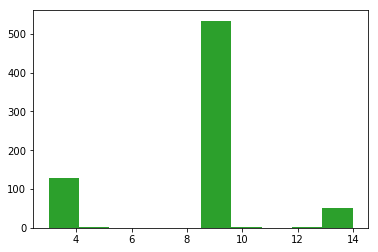

In [183]:
plt.clf()
plt.hist(loop3_length,color="#2ca02c")
plt.show()

Gaussian : mean 8.404728789986091 sigma 2.5472515503028426
Z-score 5 : 4.214872838712698 Z-score 95 : 12.594584741259482


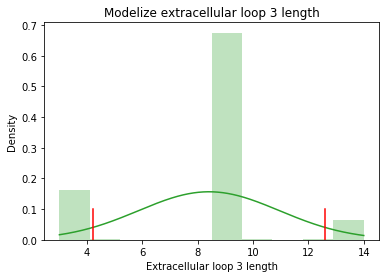

In [193]:
loop3_length_format=np.array(loop3_length).reshape(-1,1)
gaussian_model1=mixture.GaussianMixture(n_components=1)
gaussian_model1.fit(loop3_length_format)
mean1=gaussian_model1.means_[0]
sigma1=math.sqrt(gaussian_model1.covariances_[0])
weight1=gaussian_model1.weights_[0]
print("Gaussian : mean",mean1[0],"sigma",sigma1)

#mean2=gaussian_model1.means_[1]
#sigma2=math.sqrt(gaussian_model1.covariances_[1])
#weight2=gaussian_model1.weights_[1]
#print(mean2,sigma2,weight2)

#mean3=gaussian_model1.means_[2]
#sigma3=math.sqrt(gaussian_model1.covariances_[2])
#weight3=gaussian_model1.weights_[2]
#print(mean3,sigma3,weight3)

x=np.linspace(min(loop3_length),max(loop3_length),1000)
plt.clf()
plt.plot(x,weight1*stats.norm.pdf(x,mean1,sigma1),color="#2ca02c")
#plt.plot(x,weight2*stats.norm.pdf(x,mean2,sigma2),color="#2ca02c")
#plt.plot(x,weight3*stats.norm.pdf(x,mean3,sigma3),color="#2ca02c")
plt.hist(loop3_length_format,density=True,color="#2ca02c",alpha=0.3)

zscore05=stats.norm.ppf(0.05,mean1,sigma1)
zscore95=stats.norm.ppf(0.95,mean1,sigma1)
print("Z-score 5 :",zscore05[0],"Z-score 95 :",zscore95[0])

plt.plot((zscore05,zscore05),(0,0.1),color="red")
plt.plot((zscore95,zscore95),(0,0.1),color="red")
plt.xlabel("Extracellular loop 3 length")
plt.ylabel("Density")
plt.title("Modelize extracellular loop 3 length")
plt.savefig("/Users/chilpert/Results/NOX_visu_clean/Topology_groups/loop3_length.pdf")

##### Assign

In [194]:
nb_big = 0
nb_normal = 0
nb_small = 0
nb_absent = 0
for e in data_ok: 
    length=[len(f["seq"]) for f in e.loop_fragments if f["name"]=="outside_loop_3"]
    e.loop3_length=None
    if length:
        e.loop3_length=length[0]
        if length > zscore95: 
            e.group_dic["ol3"]="big"
            nb_big += 1
        elif length < zscore05:
            e.group_dic["ol3"]="small"
            nb_small += 1 
        else:
            e.group_dic["ol3"]="normal"
            nb_normal += 1
    else:
        e.group_dic["ol3"]="absent"
        nb_absent += 1

print("Small :", nb_small)
print("Normal :", nb_normal)
print("Big :", nb_big)
print("Absent :", nb_absent)

Small : 129
Normal : 540
Big : 50
Absent : 50


### 5. Where are bi-histidines ? 

In [196]:
import re
def localize_bi_histidines(e):
    helix_nb = 0
    helix_bi_histidine = []
    for h in e.helix_fragments:
        helix_nb += 1
        histidine_index = [m.start() for m in re.finditer('H', h["seq"])]
        if histidine_index:
            for i in range(len(histidine_index)):
                for j in range(i + 1, len(histidine_index)):
                    diff = histidine_index[j] - histidine_index[i]
                    if diff >= 12 and diff <= 14:
                         helix_bi_histidine.append(str(helix_nb))
    return helix_bi_histidine

In [197]:
number_pairs_list=[]
concerned_helix_list=[]
for e in data_ok:
    helix_with_bi_histidine = localize_bi_histidines(e)
    concerned_helix = ";".join(list(set(helix_with_bi_histidine)))
    nb_pairs = len(helix_with_bi_histidine)
    e.group_dic["bi-histidine_helix"]=concerned_helix
    e.group_dic["bi-histidine_pairs"]=nb_pairs
    number_pairs_list.append(nb_pairs)
    concerned_helix_list.append(concerned_helix)

['3;1', '4;2', '3;5']
[13, 37, 719]


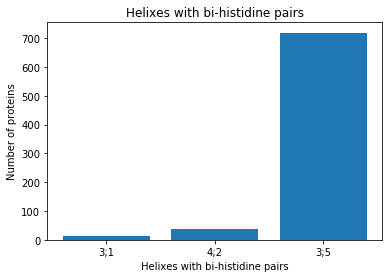

In [202]:
x=list(set(concerned_helix_list))
y=[]
for x_iter in x :
    y.append(concerned_helix_list.count(x_iter))

print(x)
print(y)
fig,ax=plt.subplots()
plt.bar(x,y)
ax.set_title("Helixes with bi-histidine pairs")
plt.xlabel("Helixes with bi-histidine pairs")
plt.ylabel("Number of proteins")
plt.savefig("/Users/chilpert/Results/NOX_visu_clean/Topology_groups/bihistidine_localization.pdf")

2 bi-histidine pairs: 728
3 bi-histidine pairs: 40
4 bi-histidine pairs: 1


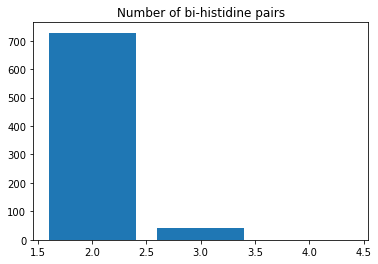

In [347]:
x=list(set(number_pairs_list))
y=[]
for x_iter in x :
    y.append(number_pairs_list.count(x_iter))

for i in range(len(x)) : 
    print(x[i], "bi-histidine pairs:", y[i])
    
fig,ax=plt.subplots()
plt.bar(x,y)
ax.set_title("Number of bi-histidine pairs")
plt.show()

#### Write output

In [348]:
f=open("/Volumes/arwen/mobi/group/NOX_clean/results/Topology_annotation/proteins_groups.tsv","w")
f_raw=open("/Volumes/arwen/mobi/group/NOX_clean/results/Topology_annotation/proteins_groups_raw.tsv","w")
f.write("Protein\tTaxid\tNumber_helixes\tAnnotated_percent_group\tNter_length_group\tCter_length_group\toutside_loop1_group\toutside_loop2_group\toutside_loop3_group\tbi_histidine_helix\tbi_histidine_pairs\n")
f_raw.write("Protein\tTaxid\tNumber_helixes\tAnnotated_percent\tNter_length\tCter_length\toutside_loop1_length\toutside_loop2_length\toutside_loop3_length\tbi_histidine_helix\tbi_histidine_pairs\n")
for e in data_ok:
    f.write(e.prot+"\t"+e.taxo.taxid+"\t"+str(len(e.helix_fragments))+"\t"+e.group_dic["annotated_fragment"]+"\t"
           +e.group_dic["Nter_length"]+"\t"+e.group_dic["Cter_length"]+"\t"+e.group_dic["ol1"]+"\t"
           +e.group_dic["ol2"]+"\t"+e.group_dic["ol3"]+"\t"+e.group_dic["bi-histidine_helix"]+"\t"
           +str(e.group_dic["bi-histidine_pairs"])+"\n")
    
    f_raw.write(e.prot+"\t"+e.taxo.taxid+"\t"+str(len(e.helix_fragments))+"\t"+str(e.annotated_percent)+"\t"+
               str(len(e.Nter_UR_fragment["seq"]))+"\t"+str(len(e.Cter_UR_fragment["seq"]))+"\t"+str(e.loop1_length)
                +"\t"+str(e.loop2_length)+"\t"+str(e.loop3_length)+"\t"+e.group_dic["bi-histidine_helix"]+"\t"
           +str(e.group_dic["bi-histidine_pairs"])+"\n")
f.close()
f_raw.close()